# Survival Analysis FM

## Where the data at?

In [1]:
input_path = '../Data/Processed_Data/'
output_path = '../Data/Processed_Data/'

## Load Datasets

In [2]:
import pandas as pd

x_train = pd.read_pickle(input_path+'embedding.pkl')
x_test = pd.read_pickle(input_path+'embedding_test.pkl')

y = pd.read_csv(input_path+'y.csv', index_col=0)

y_train = y[~y['Clinical Trial'].isin(['AML02','AML08'])]
y_train = y_train[y_train['os.evnt'].notnull()]
y_test = y[y['Clinical Trial'].isin(['AML02','AML08'])]

# Select samples in x that are in y_train
x_train = x_train.loc[y_train.index].to_numpy()
x_test = x_test.loc[y_test.index].to_numpy()

y_test.shape, y_train.shape

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Processed_Data/embedding.pkl'

## XGBoost

In [3]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'max_depth': range (2, 6, 10),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1, 10]
}

estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
xgboost = grid_search.best_estimator_
print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
COG OS ROC AUC: 0.767 
StJude OS ROC AUC: 0.676 


In [4]:
xgboost

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Grid Search

In [5]:
# # Code source: Gaël Varoquaux
# #              Andreas Müller
# # Modified for documentation by Jaques Grobler
# # License: BSD 3 clause
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

sns.set_theme(style='white')

In [6]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Random Forest",
    "Neural Net",
    "Naive Bayes",
    "QDA",
    "XGBoost",
    "Logistic Regression"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(random_state=42, n_jobs=-1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(activation='tanh', alpha=0.001, batch_size=100,
              hidden_layer_sizes=(50,), max_iter=1000),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgboost,
    LogisticRegression()
]

<AxesSubplot: >

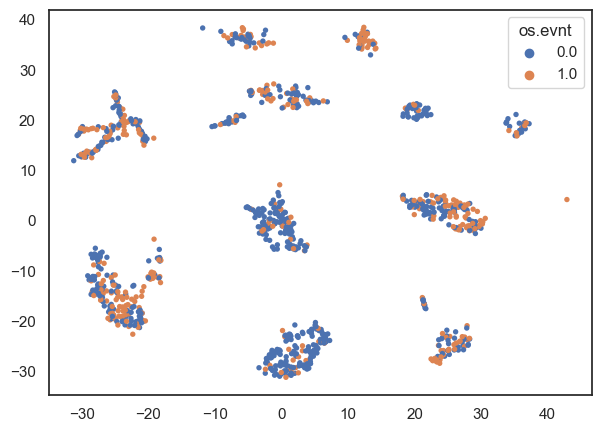

In [7]:
# Define scatterplot
sns.set_theme(style='white')

plt.subplots(figsize=(7, 5))

sns.scatterplot(data=x_train, x=x_train[:, 0], y=x_train[:, 1],
                    s=15, hue=y_train['os.evnt'],
                    linewidth=0, alpha=1)

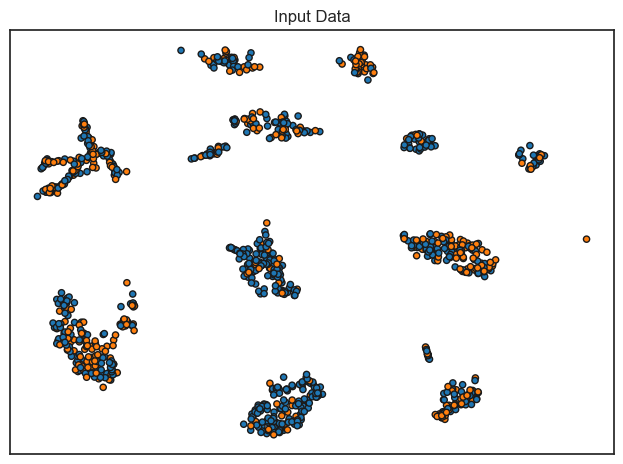

In [8]:
cm_bright = ListedColormap(['#1f77b4', '#ff7f0e'])
cm = ListedColormap(['#1f77b4', '#ff7f0e'])


ax = plt.subplot() 
# Plot the training points
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train['os.evnt'], cmap=cm_bright, edgecolors="k", s=20)
# Plot the testing points
# ax.scatter(
#     x_test[:, 0], x_test[:, 1], c=y_test['os.evnt'], cmap=cm_bright, alpha=0.6, edgecolors="k", s=20
# )

ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Input Data")

plt.tight_layout()
plt.show()

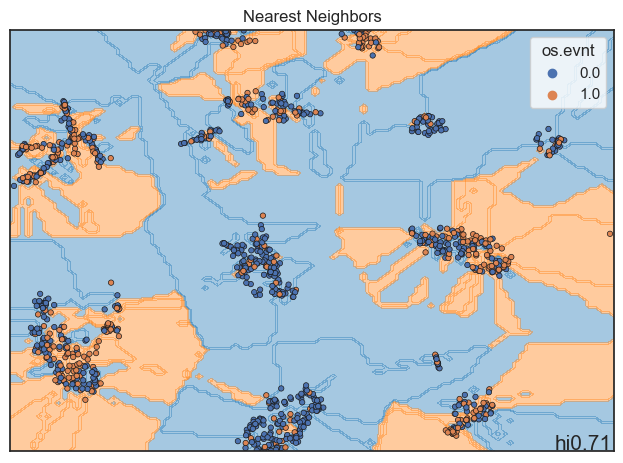

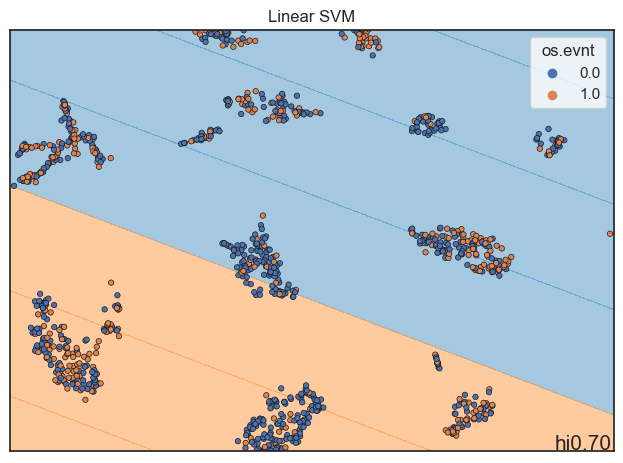

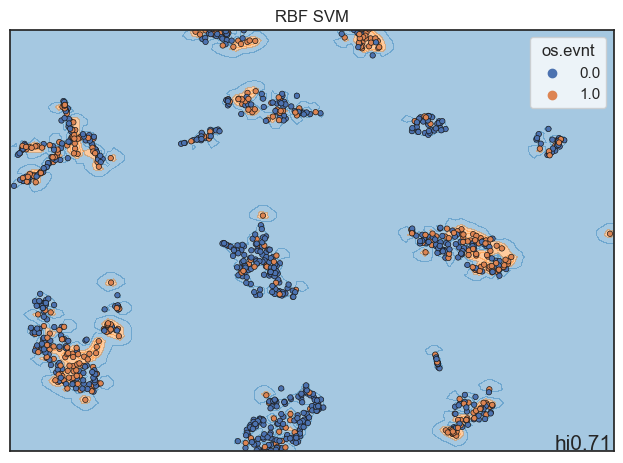

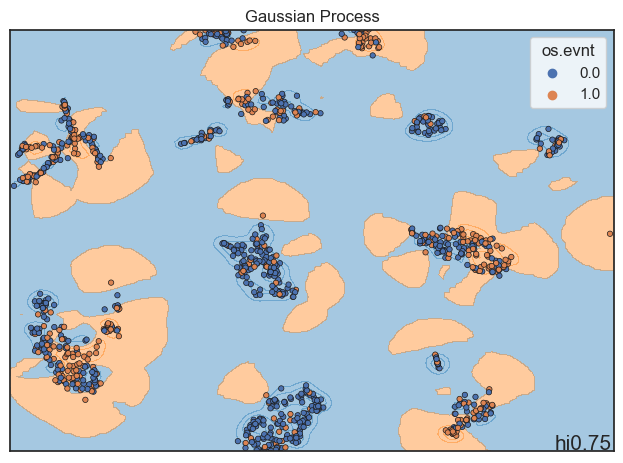

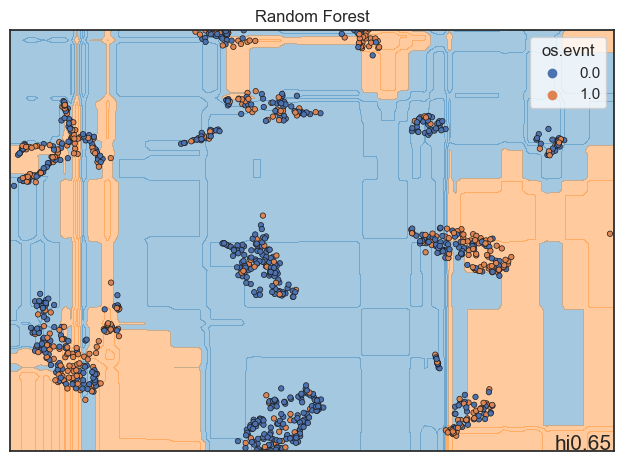

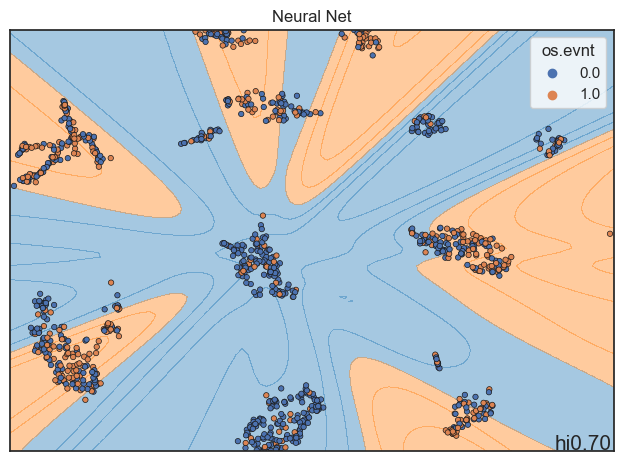

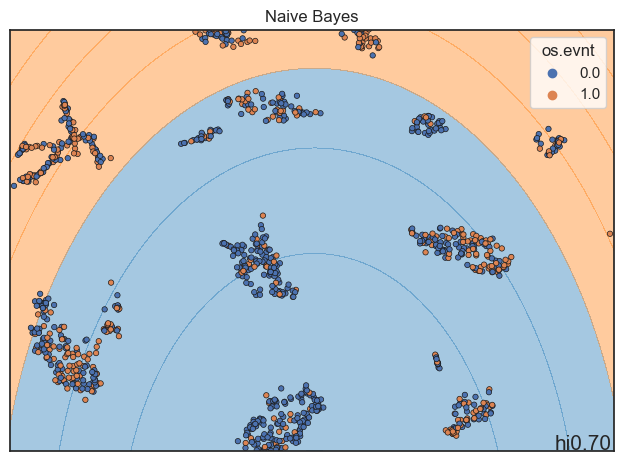

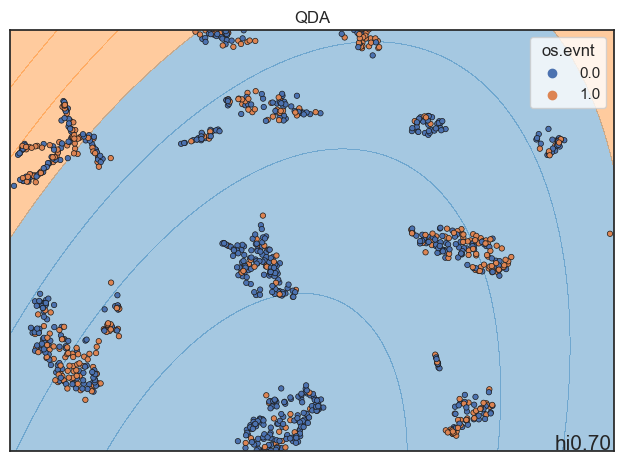

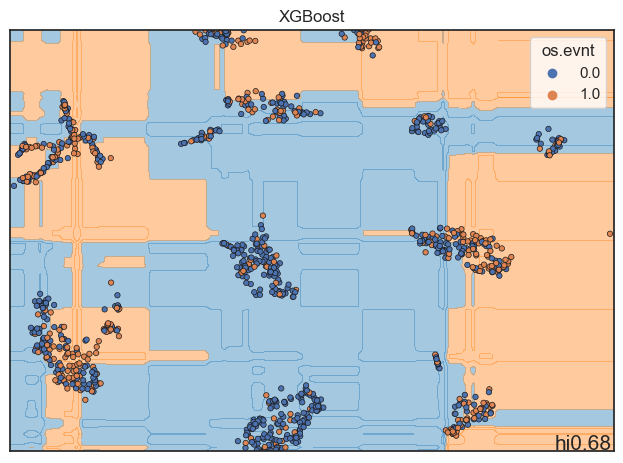

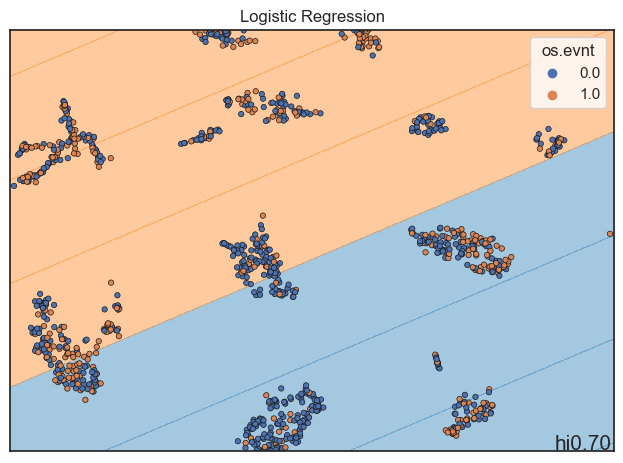

In [9]:
  
for name, clf in zip(names, classifiers):


    ax = plt.subplot() 

    x_min, x_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
    y_min, y_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5


    # Test classifier
#    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(x_train, y_train['os.evnt'])
    score = clf.score(x_test, y_test['os.evnt'])
    DecisionBoundaryDisplay.from_estimator(
        clf, x_train, cmap=cm, alpha=0.4, ax=ax, eps=0.5
    )


    sns.scatterplot(data=x_train, x=x_train[:, 0], y=x_train[:, 1],
                    s=15, hue=y_train['os.evnt'],
                    linewidth=0.5, alpha=1, ax=ax,edgecolor='k')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)

    ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("hi"+"%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()


## Model Evaluation

In [10]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF

parameters = {}

estimator = GaussianProcessClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
gpc = grid_search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [11]:

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

COG OS ROC AUC: 0.765 
StJude OS ROC AUC: 0.755 


In [12]:
gpc

GaussianProcessClassifier(n_jobs=-1, random_state=42)

## Save Predictions

In [13]:
score_name = "MethylScore"

In [14]:
y_train['MethylScore'] = model.predict(x_train)
y_train['MethylScore Categorical'] = y_train['MethylScore'].map({1:'High', 0:'Low'})
y_train['MethylScore_cat_bin'] = y_train['MethylScore']

y_test['MethylScore'] = model.predict(x_test)
y_test['MethylScore Categorical'] = y_test['MethylScore'].map({1:'High', 0:'Low'})
y_test['MethylScore_cat_bin'] = y_test['MethylScore']

C:\Users\flourenco\AppData\Local\Temp\ipykernel_6396\33214688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['MethylScore'] = model.predict(x_test)
C:\Users\flourenco\AppData\Local\Temp\ipykernel_6396\33214688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['MethylScore Categorical'] = y_test['MethylScore'].map({1:'High', 0:'Low'})
C:\Users\flourenco\AppData\Local\Temp\ipykernel_6396\33214688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Save File

In [15]:
# Save y_train and y_test in the same file
y = pd.concat([y_train, y_test])
y.to_csv(output_path+'y_MethylScore.csv')